# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

Посмотрим на данные в файле "labels":

In [2]:
labels = pd.read_csv('...')

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.tail()

,file_name,real_age
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20
7590,007612.jpg,47


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Всего в файле имеется 7591 запись о фотографиях. Файл организован двумя типами данных: object, int64. Минимальный возраст 1 год, максимальный 100 лет. Средний возраст составляет 31 год, медианный же 29 лет. 

Проверим, имеются ли дублированные названия файлов:

In [7]:
labels['file_name'].duplicated().sum()

0

Построим гистограмму возраста людей:

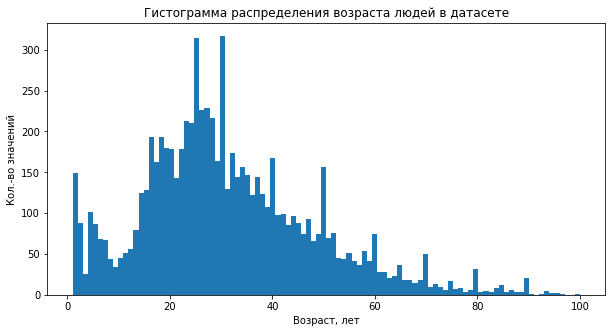

In [8]:
labels['real_age'].plot(kind='hist', bins=100, figsize=(10,5))
plt.xlabel('Возраст, лет')
plt.ylabel('Кол.-во значений')
plt.title('Гистограмма распределения возраста людей в датасете');

В имеющемся наборе данных наиболее часто представлены фотографии людей в возрасте 1...5 и 16...50 лет. Кол.-во таких фото составляет 78% датасета. В датасете имеется небольшой "провал" в данных детей в возрасте 6...15 лет, а также плавное снижение для возраста 50+. Имеющийся характер распределения может привести к тому, что модель лучше обучится на данных людей более часто встречающихся возрастов, редкие же возрасты она будет определять с худшим результатом. Чтобы избежать таких искажаний, необходимо иметь более ровную гистограмму, т.е. примерно одинаковое кол.-во людей разных возрастов.

Создадим объект класса "ImageDataGenerator" и загрузим изображения:

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=15,
        class_mode='raw',
        seed = 12345) 

Found 7591 validated image filenames.


Выведем 15 фото:

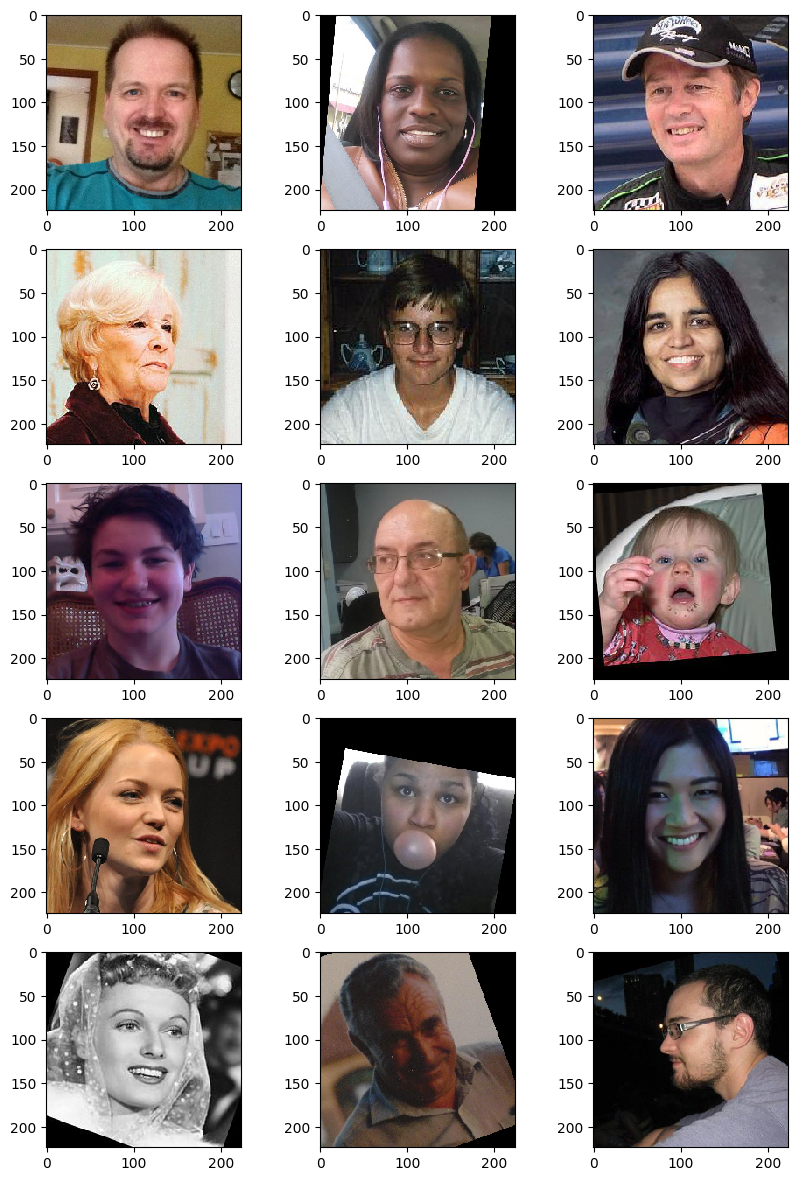

In [11]:
fig = plt.figure(figsize=(10, 15), dpi=100)
for i in range(1,16):
    ax = fig.add_subplot(5, 3, i)
    ax.imshow(np.array(train_gen_flow[0][0][i-1])) 

Представленные фотографии сделаны в разных услових, ракурсах, могут быть обрезаны, повернуты, некоторые же фотографии черно-белые. Такой разнообразный набор данных, с одной стороны, может позволить лучше натренировать модель на всевозможных фото и научить её разбираться в большем числе признаков. С другой стороны, определение возраста на тестовых данных может быть не лучшим из-за "нестандартизированных" фотографий. Вероятно, улучшить качество обучения модели поможет аугментация изображений по ориентации, цветам и другим характеристикам. Также повысить качество фотографий можно путем грамотной технической реализации системы рапознования лиц в реальных условиях.

## Обучение модели

Код обучения модели:

```python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd


def load_train(path):
#загрузка обучающих данных

    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        rescale = 1/255.,
        validation_split = 0.25)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'raw',
        subset = 'training',
        seed = 12345) 
    return train_gen_flow


def load_test(path): 
#загрузка тестовых данных    
    
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        rescale = 1/255.,
        validation_split = 0.25)    
    val_gen_flow = datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'raw',
        subset = 'validation',
        seed = 12345)     
    return val_gen_flow


def create_model(input_shape):
#создание модели ResNet    
    
    backbone = ResNet50(input_shape=input_shape, weights = 'imagenet', include_top = False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation = 'relu')) 
    optimizer = Adam(lr = 0.0001)
    model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mae'])    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=15, steps_per_epoch=None, validation_steps=None):
#обучение модели    
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)    
    return model
```

Результат вывода на экран:

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 178 steps, validate for 60 steps
Epoch 1/15

178/178 - 48s - loss: 247.9446 - mae: 11.3198 - val_loss: 1020.5143 - val_mae: 27.2706
Epoch 2/15
178/178 - 40s - loss: 63.2743 - mae: 6.0155 - val_loss: 925.2725 - val_mae: 25.5764
Epoch 3/15
178/178 - 39s - loss: 31.9115 - mae: 4.3335 - val_loss: 364.6369 - val_mae: 14.2863
Epoch 4/15
178/178 - 39s - loss: 20.7867 - mae: 3.4736 - val_loss: 111.8152 - val_mae: 8.0741
Epoch 5/15
178/178 - 39s - loss: 15.2058 - mae: 3.0096 - val_loss: 84.7104 - val_mae: 7.0743
Epoch 6/15
178/178 - 39s - loss: 10.8198 - mae: 2.5082 - val_loss: 72.5692 - val_mae: 6.3650
Epoch 7/15
178/178 - 39s - loss: 8.7569 - mae: 2.2616 - val_loss: 66.8715 - val_mae: 6.1613
Epoch 8/15
178/178 - 39s - loss: 8.2980 - mae: 2.1568 - val_loss: 67.9612 - val_mae: 6.2918
Epoch 9/15
178/178 - 39s - loss: 8.1318 - mae: 2.1604 - val_loss: 68.9719 - val_mae: 6.3670
Epoch 10/15
178/178 - 40s - loss: 7.2885 - mae: 2.0520 - val_loss: 63.7173 - val_mae: 6.0019
Epoch 11/15
178/178 - 39s - loss: 6.3355 - mae: 1.9063 - val_loss: 69.4069 - val_mae: 6.4616
Epoch 12/15
178/178 - 39s - loss: 6.1144 - mae: 1.8572 - val_loss: 66.9994 - val_mae: 6.2942
Epoch 13/15
178/178 - 39s - loss: 6.1840 - mae: 1.8632 - val_loss: 68.5664 - val_mae: 6.2438
Epoch 14/15
178/178 - 39s - loss: 5.8906 - mae: 1.8426 - val_loss: 63.4940 - val_mae: 6.0768
Epoch 15/15
178/178 - 39s - loss: 5.5746 - mae: 1.8011 - val_loss: 72.4368 - val_mae: 6.3149

60/60 - 10s - loss: 72.4368 - mae: 6.3149
Test MAE: 6.3149
```

## Анализ обученной модели

Для решения данной задачи использована нейронная сеть ResNet с 50 слоями, предобученная на наборе данных 'imagenet'. ResNet состоит из backbone, GlobalAveragePooling2D и полносвязного выходного слоя с 1 нейроном и активацией ReLU. Были получены результаты за 15 эпох обучения. Для тренировочной выборки минимальные значения  MAE (1.80), MSE (5.57) достигаются на 15 эпохе. Наименьшие значения MAE (6.00), MSE (63) на тестовой выборке достигаются уже на 10 эпохе обучения такой сети. На 15 же эпохе обучения результаты на тестовой выборке имеют не самые оптимальные показатели, что может говорить о небольшом переобучении модели. Т.о. оптимальной продолжительностью обучения для данной нейронной сети будем считать 10 эпох.

## Чек-лист

- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы